### TEST MAP

In [1]:
import os
import pandas
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

### Read GPS Triggering data

In [8]:
# load data
source_folder = "../../../data/field_map/"
south_data = "2022_10_04_09_57_34/gps_at_trigger.csv"
west_data = "2022_10_04_10_48_09/gps_at_trigger.csv"
north_path = "2022_10_04_11_05_46/gps_at_trigger.csv"
east_path = "2022_10_04_11_41_05/gps_at_trigger.csv"

all_data_csv = [south_data, west_data, north_path, east_path]
all_data_name = ['south', 'west', 'north', 'east']

# field bound
field_bound = (
    (-121.794980, -121.793920), # longitude
    (38.537990, 38.539540),     # latitude
)

# raw pandas data
all_data_pt_raw = {}
for data_csv, name in zip(all_data_csv, all_data_name) :
    raw_data = pandas.read_csv(os.path.join(source_folder, data_csv))
    all_data_pt_raw[name] = (raw_data)

# convert to numpy
all_data_pt_np = {}
for key in all_data_pt_raw.keys():
    all_data_pt_np[key] = np.vstack((all_data_pt_raw[key].lon_avg, all_data_pt_raw[key].lat_avg)).T

# convert to treeline
treeline_WE = []
for i in range(len(all_data_pt_np['west'])):
    treeline_WE.append(np.vstack((
        all_data_pt_np['west'][i],
        all_data_pt_np['east'][i],
    )))

treeline_SN = []
for i in range(len(all_data_pt_np['south'])):
    treeline_SN.append(np.vstack((
        all_data_pt_np['south'][i],
        all_data_pt_np['north'][i],
    )))

# Column-wise (index 0 start from west)
column_data = []

for i in range(len(treeline_SN)-1):
    column_data.append({
        'index': i,
        'vertice': np.vstack((
            all_data_pt_np['south'][i],
            all_data_pt_np['north'][i],
            all_data_pt_np['north'][i+1],
            all_data_pt_np['south'][i+1],
        )),
        'treelines': [
            treeline_SN[i],
            treeline_SN[i+1],
        ],
    })


# row_wise (index 0 start from south)
row_data = []
for i in range(len(treeline_WE)-1):
    row_data.append({
        'index': i,
        'vertice': np.vstack((
            all_data_pt_np['west'][i],
            all_data_pt_np['east'][i],
            all_data_pt_np['east'][i+1],
            all_data_pt_np['west'][i+1],
        )),
        'treelines': [
            treeline_WE[i],
            treeline_WE[i+1],
        ],
    })

### Utils functions

In [18]:
def configure_map_plot(axis):
    axis.set_xlabel('Longitude [deg]')
    axis.set_ylabel('Latitude [deg]')
    axis.set_aspect(1)
    axis.set_xlim(field_bound[0])
    axis.set_ylim(field_bound[1])
    axis.set_xticks(np.arange(field_bound[0][0], field_bound[0][1], 0.0003))
    axis.set_yticks(np.arange(field_bound[1][0], field_bound[1][1], 0.0003))
    axis.ticklabel_format(useOffset=False)

    return axis


def plot_polygon(axis, data, c='b'):
    axis.scatter(data['vertice'][:,0], data['vertice'][:,1], s=10, color='b')
    for k in range(2):
        axis.plot(data['treelines'][k][:,0], data['treelines'][k][:,1], color='k', linewidth=0.5)
    axis.add_patch(patches.Polygon(data['vertice'], color=c, linestyle='-', linewidth=3.0, alpha=0.05))

    return axis


### Whole map

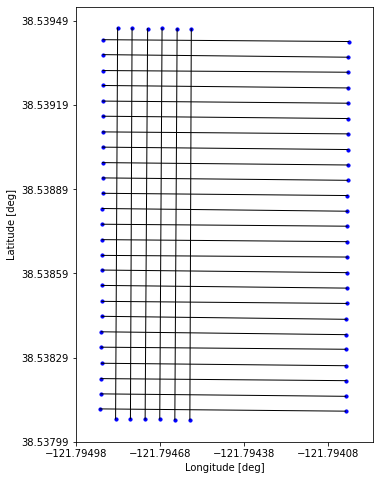

In [9]:
# plot
fig, axis = plt.subplots(1,1,figsize=(8,8))
configure_map_plot(axis)

for key in all_data_pt_np.keys():
    axis.scatter(all_data_pt_np[key][:, 0], all_data_pt_np[key][:, 1], s=10, color='b')

for i in range(len(treeline_SN)):
    axis.plot(
        treeline_SN[i][:, 0], treeline_SN[i][:, 1],
        color='k', linewidth=1.0
    )

for i in range(len(treeline_WE)):
    axis.plot(
        treeline_WE[i][:, 0], treeline_WE[i][:, 1],
        color='k', linewidth=1.0
    )



### Single row

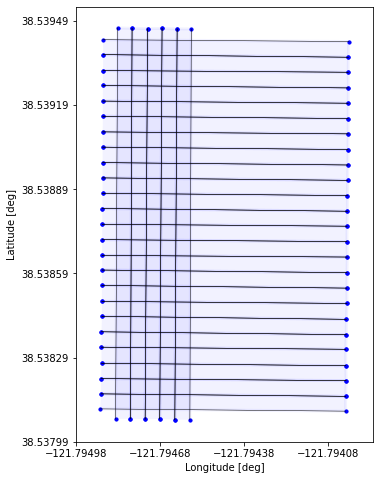

In [19]:
fig, axis = plt.subplots(1,1,figsize=(8,8))
configure_map_plot(axis)

for i in range(24):
    _ = plot_polygon(axis, row_data[i])


for i in range(5):
    _ = plot_polygon(axis, column_data[i])
